<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/vectorizer_pub_embedder_litely.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# your favorite vectorizer research embedding, automated
dan ehlers (pinballsurgeon@gmail.com)




1. installs

In [2]:
# arxiv libraries
!pip install arxiv

# pdf ocr
!pip install pdfplumber -q

2. dependencies

In [3]:
import numpy
import pandas
import arxiv
import pdfplumber
import os
import tensorflow_hub
import seaborn

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = tensorflow_hub.load(module_url)

3. configuration(s)

In [4]:
# configs
max_results_per_vectorizer = 20

# yr standard colab issued directory
dir = '/content/'

# yr preferred vectorizers
vectorizers = ['fasttext'
              ,'GloVe'
              ,'BERT'
              ,'word2vec']

4. helper function(s)

In [5]:
### 4.1 paper to vectorizer relationship lookup
def paper2vect_map_func(paper_title, vect_dict, vect_buffer = ""):
  
  # check each paper
  for key in vect_dict:

      # if iterative paper match lookup paper
      if paper_title in key:
          vect_buffer = vect_dict[key]

  # return vectorizer type
  return vect_buffer


5. list and download vectorizer pdfs, as limited by submit date

In [6]:
# initialize paper to vectorizer lookup dictionary (paper : vectorizer)
paper2vect_map = {}

# for each vectorizer, perform search per submit date
for vectorizer in vectorizers:

  # arxiv api search call
  search = arxiv.Search(
      query = vectorizer,
      max_results = max_results_per_vectorizer,
      sort_by = arxiv.SortCriterion.SubmittedDate )

  # each topics return
  for result in search.results():

    # retrieve selected paper (clean yr arxiv id firstly)
    paper = next(arxiv.Search(id_list=[result.entry_id.rsplit('/', 1)[1]]).results())

    # download to yr pwd
    paper.download_pdf()

    # update lookup dictionary (paper : vectorizer)
    paper2vect_map[result.entry_id] = vectorizer
    

6. ingest into text, local pdf via ofr.  build dataframe w/ essential relationships

In [7]:
# blank frames and lists
df = pandas.DataFrame()
lst_titles = []
lst_text = []
lst_vect_type = []

# for each pdf reasearch
for filename in os.listdir(dir):
    f = os.path.join(dir, filename)

    # ingest pdfs
    if os.path.isfile(f):
        pdf = pdfplumber.open(f)
        page = pdf.pages[0]
        text = page.extract_text()

        # clean title from file name/path
        papers_title = (f.rsplit('/', 1)[1]).rsplit('.', 1)[0]

        # quintessential lists
        lst_titles.append(papers_title)       # build column for paper's title
        lst_text.append(text)                 # build column for paper's total text
        lst_vect_type.append(                 
            paper2vect_map_func(papers_title.rsplit('.', 1)[0]
                      , paper2vect_map))      # build column for paper's vectorizer

# quintessential dataframe
df['titles'] = lst_titles
df['text'] = lst_text
df['vect_type'] = lst_vect_type


7. embed and plot

Text(0.5, 1.0, 'Similarity')

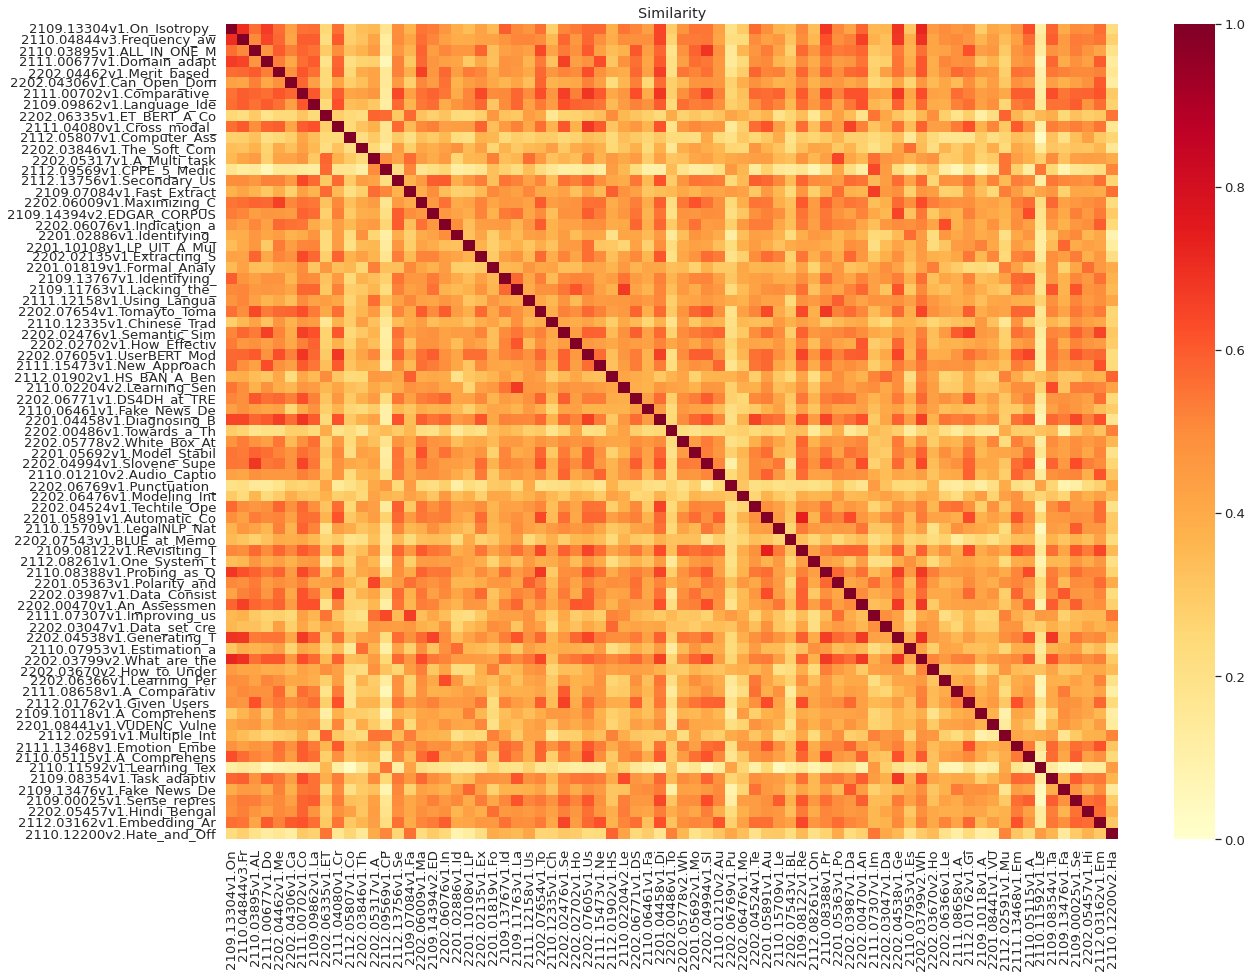

In [10]:
# embed sentences
message_embeddings_ = model(df['text'])

# array product (build our 2d universe)
corr = numpy.inner(message_embeddings_, message_embeddings_)

# seaborn config
seaborn.set(font_scale=1.2, rc={'figure.figsize':(20,15)})

# seaborn plot
g = seaborn.heatmap(
    corr,
    xticklabels=df['titles'].str.slice(0,25), # vect paper titles, sliced for nice
    yticklabels=df['titles'].str.slice(0,25), # vect paper titles
    vmin=0,
    vmax=1,
    cmap="YlOrRd")

# rotate and label
g.set_xticklabels(df['titles'].str.slice(0,15), rotation=90)
g.set_title("Similarity")
